# Understanding `pycheops` using data of KELT-11 I: data download and visualisation

In the following notebook, we will play with CHEOPS data of KELT-11 data with an intention to understand various functionalities of `pycheops`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import juliet
import pycheops
from dace.cheops import Cheops

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Using DACE

In [2]:
data = Cheops.query_database()

# Name of the target
data['obj_id_catname']

['Pollux',
 'KELT-11b',
 'HD88111',
 'Fomalhaut',
 'HD88111',
 'Fomalhaut',
 'TESS_260647166',
 'TESS_260647166',
 'Pollux',
 'Altair',
 'KELT-11b',
 'TYC5502-1037-1',
 'Altair',
 'TYC5502-1037-1']

In [3]:
# To print the keys of dictinary
data.keys()

dict_keys(['obj_id_catname', 'obj_pos_coordinates_hms_dms', 'date_mjd_start', 'date_mjd_end', 'obj_mag_v', 'pi_name', 'prog_id', 'req_id', 'data_arch_rev', 'status_published', 'obs_exptime', 'photom_ap_radius', 'obs_id', 'data_pipe_version', 'photom_ap_type', 'pi_uid', 'prog_type', 'obj_mag_cheops', 'obj_mag_cheops_err', 'obj_sptype', 'obs_nexp', 'photom_lc_dataname', 'obs_total_exptime', 'data_proc_num', 'db_lc_available', 'file_rootpath', 'file_ext', 'ins_name', 'file_key', 'obj_mag_v_err'])

One can use `filter` keyword in `query_database` to query specific options from the database. For example, if I want to find all the object observed by KELT, I would try to find keyword 'KELT' in `obj_id_catname` - that is the name of the objects in the database (see below).

In [4]:
# Filters
fltr = {'obj_id_catname': {'contains':'KELT', 'notContains':'WASP', 'empty':False}}
data = Cheops.query_database(filters=fltr)
data['obj_id_catname'], data['file_key']

(['KELT-11b', 'KELT-11b'],
 ['CH_PR300024_TG000101_V0200', 'CH_PR300024_TG000101_V0101'])

The filter worked! We only got those objects in database which are observed by 'KELT' survey. Along with their names we printed the so-called `file_key` of the data. This is important keyword --- because this is what we essentially need while downloading data-products.

Note that there are two different file keys for the same object. We would think that this is because they have observed the same target twice. But this is not the case --- we can plot the lightcurves from these two files and check this detail, which we do below.

In [5]:
# To download the lightcurve
target_lc = Cheops.get_lightcurve(target='KELT-11b', aperture='Optimal')
# Note that one can also download full images from the Dace using the following command
# Cheops.download(file_type='images', filters=fltr, output_directory=os.getcwd())
# But keep in mind that this will download all (literally all) data available for the given target(s).
# This may take a while, and the file size may be large ~1.5GB.

# This command would give a dictionary containing data
# Its keys are,
target_lc.keys()

dict_keys(['photom_flux_vect_err', 'obj_date_bjd_vect', 'photom_conta_lc_vect_err', 'photom_centroid_x_vect', 'photom_centroid_y_vect', 'photom_roll_angle_vect', 'photom_background_vect', 'photom_conta_lc_vect', 'photom_flux_vect', 'file_key'])

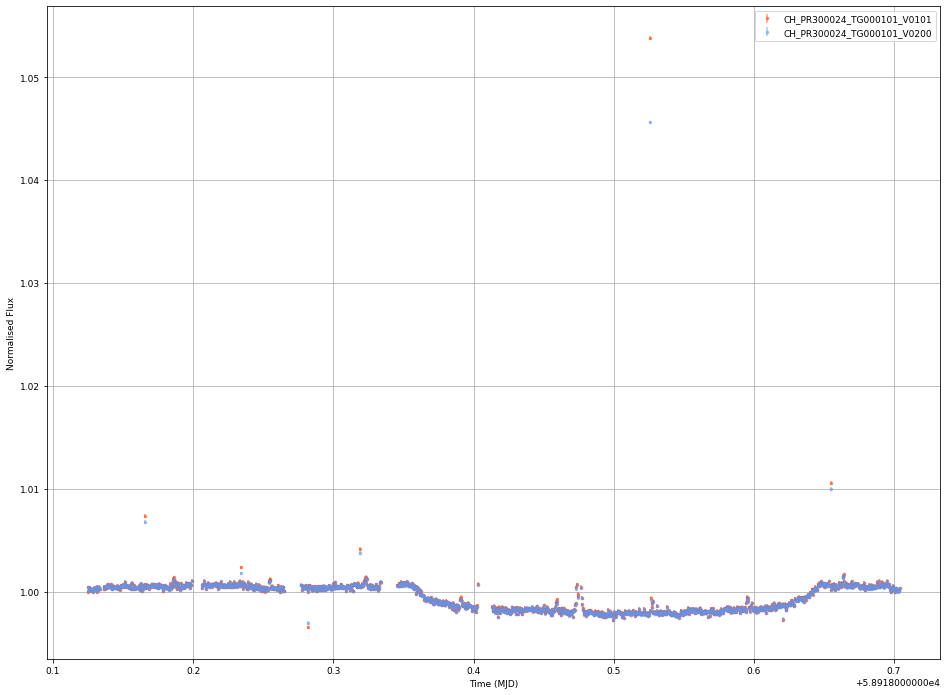

In [6]:
# Accessing the data from the dictionary and plotting it
tim1, tim2, fl1, fl2, fle1, fle2 = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for i in range(len(target_lc['file_key'])):
    if target_lc['file_key'][i] == 'CH_PR300024_TG000101_V0101':
        tim1, fl1, fle1 = np.hstack((tim1, target_lc['obj_date_bjd_vect'][i])), np.hstack((fl1, target_lc['photom_flux_vect'][i])),\
             np.hstack((fle1, target_lc['photom_flux_vect_err'][i]))
    else:
        tim2, fl2, fle2 = np.hstack((tim2, target_lc['obj_date_bjd_vect'][i])), np.hstack((fl2, target_lc['photom_flux_vect'][i])),\
             np.hstack((fle2, target_lc['photom_flux_vect_err'][i]))

# Plotting the data
plt.figure(figsize=(16,12))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.', c='orangered', alpha=0.5, label='CH_PR300024_TG000101_V0101')
plt.errorbar(tim2, fl2, yerr=fle2, fmt='.', c='cornflowerblue', alpha=0.5, label='CH_PR300024_TG000101_V0200')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalised Flux')
plt.legend()
plt.grid()

We can zoom on the actual lightcurve to see the difference between both lightcurves (that is, for the sake of a better visualisation, we omit outliers).

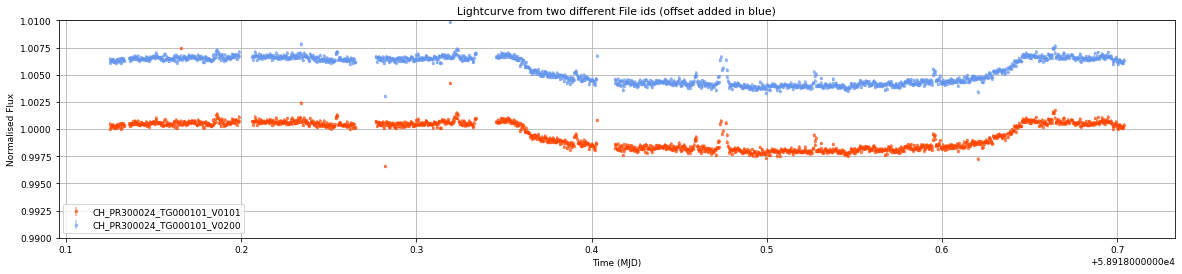

In [7]:
plt.figure(figsize=(20,4))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.', c='orangered', alpha=0.5, label='CH_PR300024_TG000101_V0101')
plt.errorbar(tim2, fl2+0.006, yerr=fle2, fmt='.', c='cornflowerblue', alpha=0.5, label='CH_PR300024_TG000101_V0200')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalised Flux')
plt.legend()
plt.ylim([0.99,1.01])
plt.title('Lightcurve from two different File ids (offset added in blue)')
plt.grid()

It is now clear that both lightcurves are not of different observations (they have the same time). But, in fact, they produced from different version of data reduction pipelines. Since the file id ending with `..._V0200` indicates the usage of a later version of pipeline, we shall use that file id only in our analysis.

## Using `pycheops`

Now, we shall demonstrate the usage of `pycheops` in downloading and visualising the data.

In [8]:
# Downloading the data
# Once it is downloaded, it can find archieve
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03


Now, we can visualise the data,

In [9]:
help(dd.get_lightcurve)

Help on method get_lightcurve in module pycheops.dataset:

get_lightcurve(aperture=None, decontaminate=None, returnTable=False, reject_highpoints=False, verbose=True) method of pycheops.dataset.Dataset instance
    :param aperture: 'OPTIMAL', 'DEFAULT', 'RSUP' or 'RINF'
    :param decontaminate: if True, subtract flux from background stars 
    :param returnTable: 
    :param reject_highpoints: 
    :param verbose:
    
    The offset of the telescope tube temperature from its nominal value 
    (thermFront_2 + 12) is stored in dataset.lc['deltaT']



Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
C_cut = 39629816
N(C > C_cut) = 4
Mean counts = 39495521.5
Median counts = 39511341.9
RMS counts = 46070.5 [1166 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 358931 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm


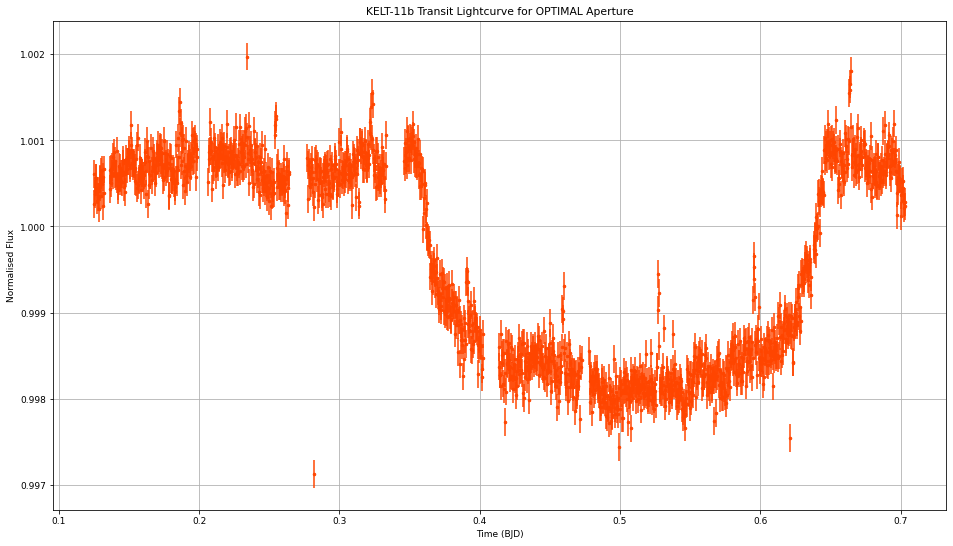

In [10]:
# To get lightcurves from 
# decontaminate is being used for omiting points with photon contamination from nearby sources
# reject_highpoints arguments enables sigma-clipping
# Return only lightcurve (meaning time, flux and flux_err)
tim3, fl3, fle3 = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True, reject_highpoints=True)

# Plotting the lightcurve
plt.figure(figsize=(16,9))
plt.errorbar(tim3, fl3, yerr=fle3, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('KELT-11b Transit Lightcurve for OPTIMAL Aperture')
#plt.ylim([0.9950, 1.0050])
plt.grid()

In [11]:
# This will give all the information hidden in the lightcurve such as roll-angle, smear etc.
more_data = dd.lc
more_data.keys()

dict_keys(['time', 'flux', 'flux_err', 'bjd_ref', 'table', 'header', 'xoff', 'yoff', 'bg', 'contam', 'smear', 'deltaT', 'centroid_x', 'centroid_y', 'roll_angle', 'aperture'])

### Sub-arrays and imagettes
Sub-arrays: 200x200 pixels centered on the target

Imagettes: 50x50 pixels centered on PSF of the target (only product produced when the exposure time is short)

Subarray data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-SubArray.fits


  0%|          | 0/154 [00:00<?, ?it/s]

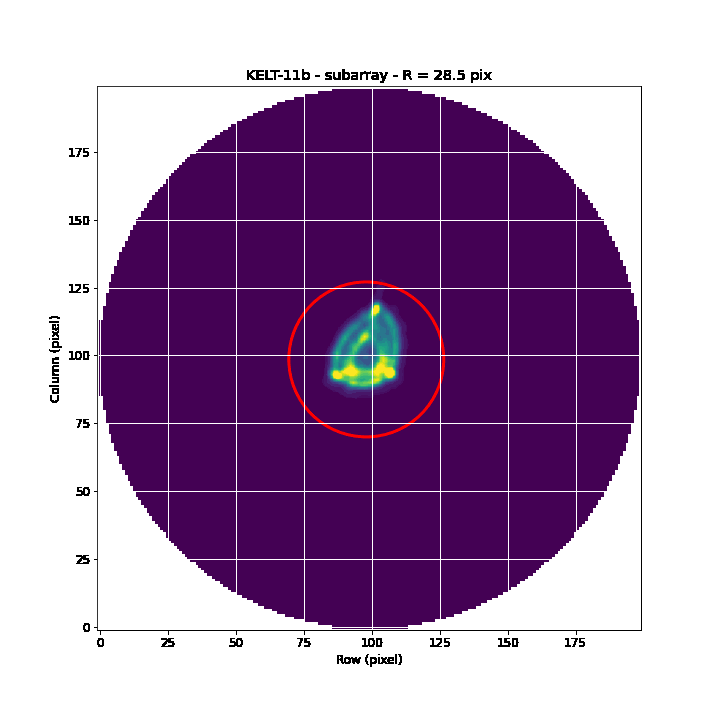

Subarray is saved in the current directory as KELT-11b-subarray-R=28.5pix.gif


In [13]:
dd.animate_frames(vmax=0.5, subarray = True, grid = True)

For some reason, `animate_frames` with `imagette=True` is not working -- it'd be a minor error though! At the moment, I do not want to waste time on this. So I will be moving forward...